In [2]:
#get larlite
from larlite import larlite as ll
from larlite import larutil as lu

geo=lu.Geometry.GetME()
geoH=lu.GeometryHelper.GetME()

import ROOT

In [3]:
#graphics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#create storage manager
sm = ll.storage_manager()
sm.set_io_mode(ll.storage_manager.kREAD)
FILENAME="../../App/mac/test_output.root"
sm.add_in_filename(FILENAME)
sm.open()

True

In [5]:
#there is only 1 event
sm.next_event()

True

In [6]:
#get hits and clusters
event_hits     = sm.get_data(ll.data.kHit,"gaushit")
event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")

#get ass
event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")

#get association
cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())

#get the vertex_data
event_vertex = sm.get_data(ll.data.kVertex,"numuCC_vertex")

#get contour data
event_user = sm.get_data(ll.data.kUserInfo,"ImageClusterHit")

In [7]:
import root_numpy as rn
gausdata = rn.root2array(FILENAME,
                        treename='hit_gaushit_tree',
                        branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                  'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                  'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

import pandas as pd
evt=0
hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                       'PeakTime'  : gausdata[evt][0],
                       'Plane'     : gausdata[evt][2]})

In [8]:
print "There are...",cluster_to_hit_ass.size()," clusters."

There are... 173  clusters.


In [9]:
#How much data is in event_user?
print event_user.size()

3


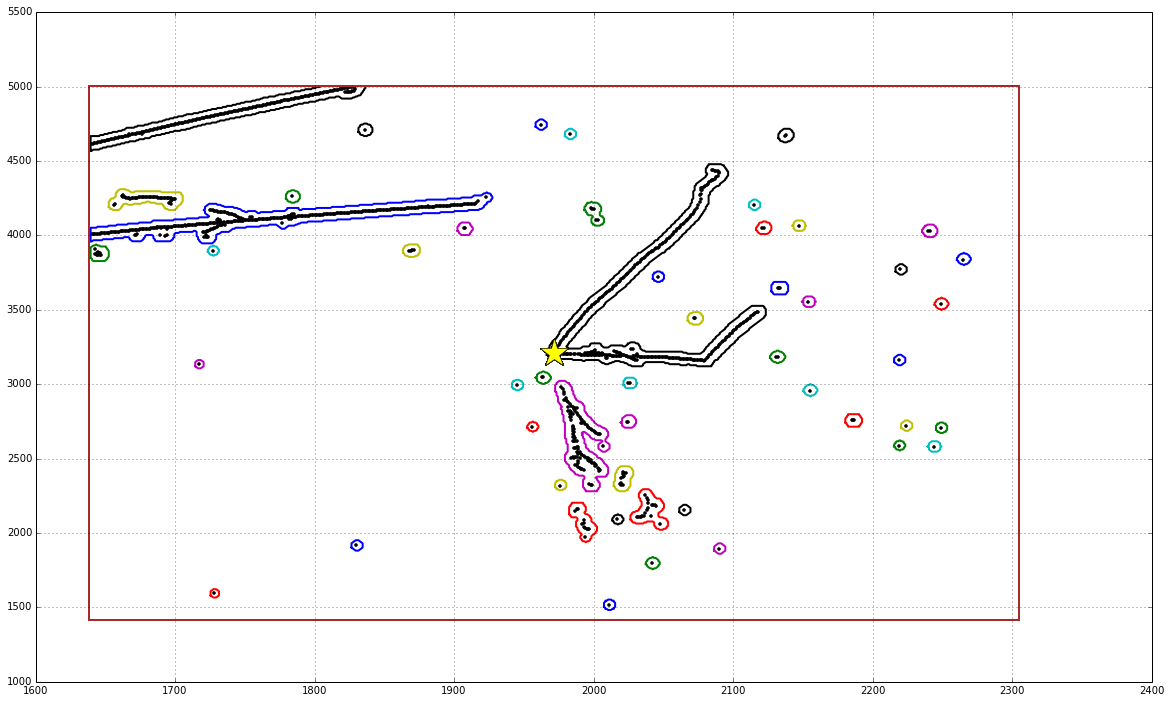

In [10]:
#Show the ImageClusters
plane=2
sbc_data=event_user[plane]
hsv = plt.get_cmap('jet')
lors = hsv(np.linspace(0, 1.0, cluster_to_hit_ass.size()))

fig,ax=plt.subplots(figsize=(10*2,6*2))
c=-1
# plot each cluster and userinfo
for ix,cluster in enumerate(cluster_to_hit_ass):
    
    #get the hits for this clusters
    slice_=np.array(cluster)
    if event_clusters[ix].Plane().Plane != plane: continue
    if slice_.size == 0: continue
        
    c+=1

    hslice = hits_df.iloc[slice_]
    
    ax.plot(hslice.Wire,hslice.PeakTime,'o',color='black',markersize=3)
    
    #call user_info get_darray, for the contour   
    xx=np.array(sbc_data.get_darray('sbc_{}_{}_x'.format(plane,c)))
    yy=np.array(sbc_data.get_darray('sbc_{}_{}_y'.format(plane,c)))

    xx=np.append(xx,xx[0])
    yy=np.append(yy,yy[0])

    plt.plot(yy,xx,'-',lw=2)
    
    vtx=ROOT.std.vector('double')()
    vtx.resize(3)
    vtx[0]=event_vertex[0].X()
    vtx[1]=event_vertex[0].Y()
    vtx[2]=event_vertex[0].Z()
    px = geoH.Point_3Dto2D(vtx.data(),plane)
    pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
    
    ax.plot(pt[0],pt[1],'*',markersize=30,color='yellow')
    
        
    bbx=np.array(sbc_data.get_darray('roi_bounds_{}_w'.format(plane)))
    bby=np.array(sbc_data.get_darray('roi_bounds_{}_t'.format(plane)))

    bbx=np.append(bbx,bbx[0])
    bby=np.append(bby,bby[0])

    plt.plot(bbx,bby,'-',lw=2,color='brown')
    
plt.grid()
plt.show()

In [11]:
#We don't have an ability to store the image into the ROOT file i don't think, so lets just make one
import cv2

#Get the plane 2 hits as a matrix (wire/peaktime) and round down to the nearest int32
h=hits_df.query('Plane==2').as_matrix(columns=['Wire','PeakTime']).astype(np.int32)

In [12]:
#make a fake image called k
k=np.zeros((3500,6400))

In [13]:
#slice on k, put a 1 where the wire/tick contains a pixel
k[h[:,0],h[:,1]]=1

In [14]:
#verify we got the dimensions right for our image
print h[:,0].min()
print h[:,0].max()
print h[:,1].min()
print h[:,1].max()

0
3455
0
6391


In [15]:
#Hits are 1 pixel big, lets blur them to make them a bit bigger
kblur=cv2.blur(k,ksize=(10,10))

#Threshold the image
kblur[kblur > 0]=1.0

In [16]:
#downsample the image so that it doesn't take for ever to display with imshow
kout=cv2.resize(kblur,(kblur.shape[0]/5,kblur.shape[1]/5))

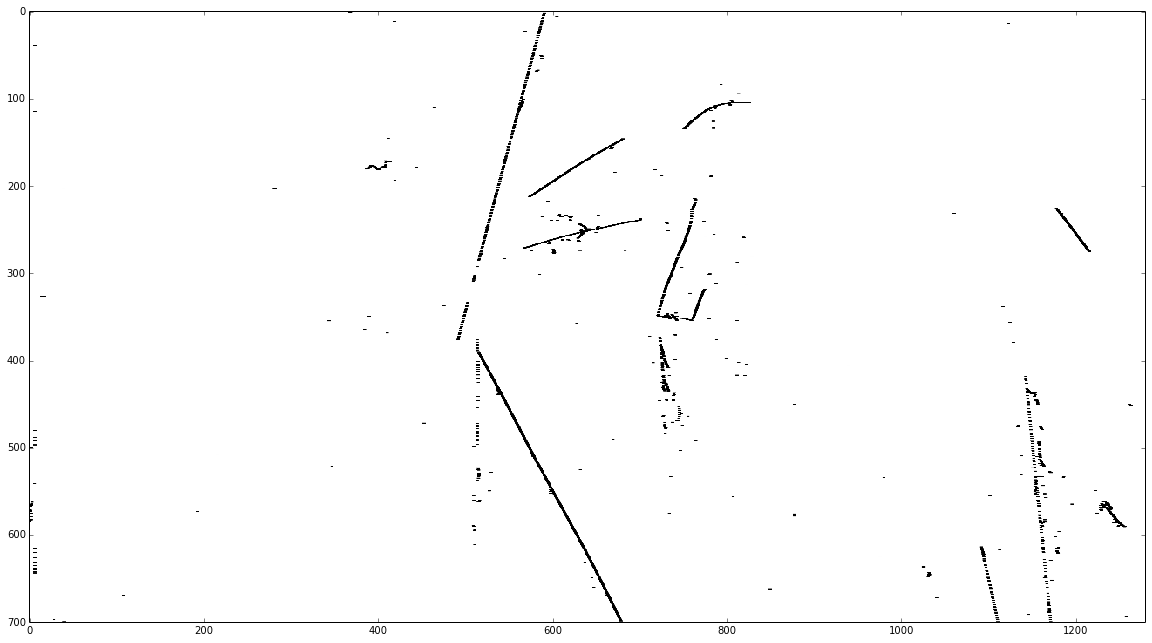

In [17]:
#what did we get?
fig,ax=plt.subplots(figsize=(20,20))
plt.imshow(kout.T[::-1,...],cmap='Greys',interpolation='none')
plt.show()

In [18]:
#kout is our image, lets run HoughLineP on it for giggles, but first it has to be 8 bits
#at the same time i'll invert it for imshow
k8bits=kout.astype(np.uint8).T[::-1,...]

In [53]:
#get the hough lines
hlp = cv2.HoughLinesP(k8bits,
                      rho=1.0,
                      theta=np.pi/180.0,
                      threshold=75, #only best lines possible
                      minLineLength=80,
                      maxLineGap=10)

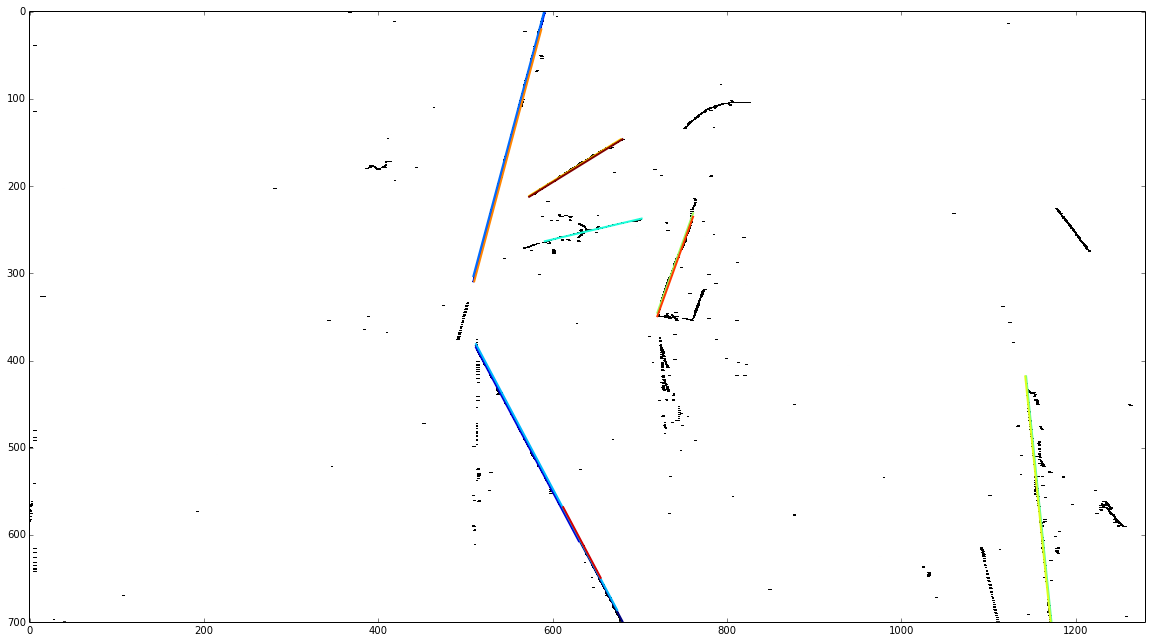

In [54]:
#what did we get?
fig,ax=plt.subplots(figsize=(20,20))
plt.imshow(k8bits,cmap='Greys',interpolation='none')

lors = hsv(np.linspace(0, 1.0, hlp.shape[0]))

for ix, hh in enumerate(hlp):
    l=matplotlib.lines.Line2D([hh[:,0],hh[:,2]],
                              [hh[:,1],hh[:,3]],lw=2,color=lors[ix])
    ax.add_line(l)
    
plt.show()